# Training and finding best model for the submission

In [26]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [27]:
# loading data
df = pd.read_csv("../data2/train.csv", index_col='id')
test_df = pd.read_csv("../data2/test.csv", index_col='id')

In [28]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [29]:
len(df.engine.unique())

1117

In [30]:
# functions

# function to handle transmission 
def get_transmission_type(text):
    if 'M/T' in text or 'Manual' in text:
        return 'Manual'
    elif 'A/T' in text or 'Automatic' in text:
        return 'Automatic'
    elif 'CVT' in text:
        return 'CVT'
    else:
        return 'Other'

def get_num_speeds(text):
    match = re.search(r'(\d+)-Speed', text)
    if match:
        return int(match.group(1))
    else:
        return 0

def get_shift_mode(text):
    if 'Dual Shift' in text or 'Auto-Shift' in text:
        return 'Dual/Auto-Shift'
    elif 'Manual' in text:
        return 'Manual'
    else:
        return 'Standard'

def get_transmission_technology(text):
    if 'DCT' in text:
        return 'DCT'
    elif 'CVT' in text:
        return 'CVT'
    elif 'Auto-Shift' in text:
        return 'Auto-Shift'
    else:
        return 'unknown'

def get_production_status(text):
    if 'SCHEDULED' in text:
        return 1
    else:
        return 0


# extract horse power
def extract_hp(text):
    '''func to extract hp'''
    hp_match = re.search(r'(\d+\.?\d*)HP', text)
    return float(hp_match.group(1)) if hp_match else 0

# extract fuel capacity
def extract_fc(text):
    '''func to extract fuel capacity'''
    fc_match = re.search(r'(\d+\.?\d*)L', text)
    return float(fc_match.group(1)) if fc_match else 0




def feature_extractor(df):
    '''func to extract features from the dataframe'''
    df = df.copy()
    df['horse_power'] = df['engine'].apply(extract_hp)
    df['fuel_capacity'] = df['engine'].apply(extract_fc)
    df['trans_type'] = df.transmission.apply(get_transmission_type)
    df['num_speed'] = df.transmission.apply(get_num_speeds)
    df['shift_mode'] = df.transmission.apply(get_shift_mode)
    df['trans_tech'] = df.transmission.apply(get_transmission_technology)
    df['prod_status'] = df.transmission.apply(get_production_status)
    df['age'] = 2025 - df.model_year
    df['milage_per_year'] = (df['milage'] / df['age'])
    df['score'] = df['horse_power'] + df['fuel_capacity'] + df['num_speed'] + df['milage_per_year']
    

    return df


def handle_nan(df):
    '''func to handle missing values'''
    df = df.copy()
    df['fuel_type'] = df['fuel_type'].replace([np.nan, '–'], 'missing')
    df['accident'] = df['accident'].replace([np.nan], 'None reported')
    df['clean_title'] = df['clean_title'].replace(np.nan, 'no')
    
    return df

In [31]:
# applying transformation
df = feature_extractor(df)
df = handle_nan(df)



# doing same for test_df
test_df = feature_extractor(test_df)
test_df = handle_nan(test_df)

In [32]:
# bining 
ord_col = ['brand', 'model', 'ext_col', 'int_col', 'fuel_type', 'engine', 'transmission']
cat_col = ['accident', 'clean_title', 'trans_type', 'shift_mode', 'trans_tech', 'prod_status']
num_col = [ 'horse_power', 'fuel_capacity', 'num_speed', 'age', 'milage_per_year', 'score']
drop_col = ['model_year', 'milage', 'price']

In [33]:
# applying transformation 
target = df['price']
df = df.drop(drop_col, axis=1)


# removing price as price is not in drop col
drop_col.remove('price')

# droping form test_df
test_df = test_df.drop(drop_col, axis=1)


col_names = df.columns.tolist()

In [34]:

# transformation pipeline
trans_pipe = ColumnTransformer([
    ('num', StandardScaler(), num_col),
    ('cat', OneHotEncoder(drop='if_binary'), cat_col),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=2000), ord_col)
], remainder='passthrough')

trans_df = trans_pipe.fit_transform(df)
trans_test_df = trans_pipe.transform(test_df)

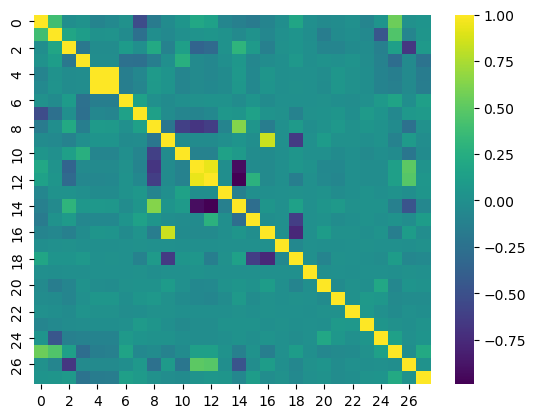

In [38]:
# find out correlation with price
temp_df = pd.DataFrame(data=trans_df)
temp_df['price'] = target

sns.heatmap(temp_df.corr(), cmap='viridis')
plt.show()

In [20]:
# model training
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(trans_df, target, test_size=0.3, random_state=42)

# model training
model = LinearRegression()

model.fit(X_train, y_train)

# metrics printing
print("Linear model rmse:", mean_squared_error(y_test, model.predict(X_test), squared=False))
print("Linear model R2 Score:", r2_score(y_test, model.predict(X_test)))


Linear model rmse: 67980.35171091204
Linear model R2 Score: 0.12488491870788543


C:\Users\mohit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
# lasso
lasso = Lasso(100)
lasso.fit(X_train, y_train)
print("Lasso model rmse:", mean_squared_error(y_test, lasso.predict(X_test), squared=False))
print("Lasso model R2 Score:", r2_score(y_test, lasso.predict(X_test)))


Lasso model rmse: 68034.32521132934
Lasso model R2 Score: 0.12349475894790707


C:\Users\mohit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
from sklearn.linear_model import LassoCV

# lassoCV
lassocv = LassoCV(n_alphas=1000)
lassocv.fit(X_train, y_train)
print("LassoCV model rmse:", mean_squared_error(y_test, lassocv.predict(X_test), squared=False))
print("LassoCV model R2 Score:", r2_score(y_test, lassocv.predict(X_test)))


LassoCV model rmse: 68715.98123584749
LassoCV model R2 Score: 0.10584283939197914


C:\Users\mohit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
# ridge
ridge = Ridge(200)
ridge.fit(X_train, y_train)
print("Ridge model rmse:", mean_squared_error(y_test, ridge.predict(X_test), squared=False))
print("Ridge model R2 Score:", r2_score(y_test, ridge.predict(X_test)))



Ridge model rmse: 67989.46144654337
Ridge model R2 Score: 0.12465036266376373


C:\Users\mohit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
# using ensemble techniques

import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(trans_test_df)

param = {
    'objective' : "reg:squarederror",
    'max_depth' : 5,
    'eta' : 0.07,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8
}

num_rounds = 100

bst = xgb.train(param, dtrain, num_rounds)

print("xgboost model rmse:", mean_squared_error(y_test, bst.predict(dtest), squared=False))
print("XGBoost model R2 Score:", r2_score(y_test, bst.predict(dtest)))



xgboost model rmse: 66292.26624556865
XGBoost model R2 Score: 0.1678069829940796


C:\Users\mohit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
print("dt model rmse:", mean_squared_error(y_test, dt_reg.predict(X_test), squared=False))
print("dt model R2 Score:", r2_score(y_test, dt_reg.predict(X_test)))

Ridge model rmse: 101938.29785055968
Ridge model R2 Score: -0.9677644445068478


C:\Users\mohit\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
xgboost_prediction = bst.predict(d_test)

def submission_file_maker(predicted_price, model_name):
    sub = pd.DataFrame({
        'id': test_df.index,
        'price': predicted_price
    })

    sub.to_csv(f"../data2/submission_{model_name}.csv", index=False)

submission_file_maker(xgboost_prediction, 'xgb_predictions')

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_reg.fit(X_train, y_train)

print("rf_reg model rmse:", mean_squared_error(y_test, rf_reg.predict(X_test), squared=False))
print("rf_reg model R2 Score:", r2_score(y_test, rf_reg.predict(X_test)))